# Space Mice Genes
## Heat Propagation and Clustering Package
### Python 2 compatible version

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 6th April, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)

## Background
<a id='background'></a>

## Import packages
<a id='import'></a>

In [170]:
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)

import Heat2
reload(Heat2)

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Define Analysis Preferences
<a id='pref'></a>

In [171]:
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

heat = Heat2.Heat(gene_type = symbol, species = mouse)

## Load Networks
<a id='load'></a>

1. Load STRING background network
2. Load DEG file 

In [172]:
#filename = '../../background_networks/10090.protein.links.v10.5.txt'
#heat.load_STRING_links(filename, confidence_filter = 700)

#print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))

In [173]:
#saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

In [181]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.02, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

Number of DEG's: 45


## Localization

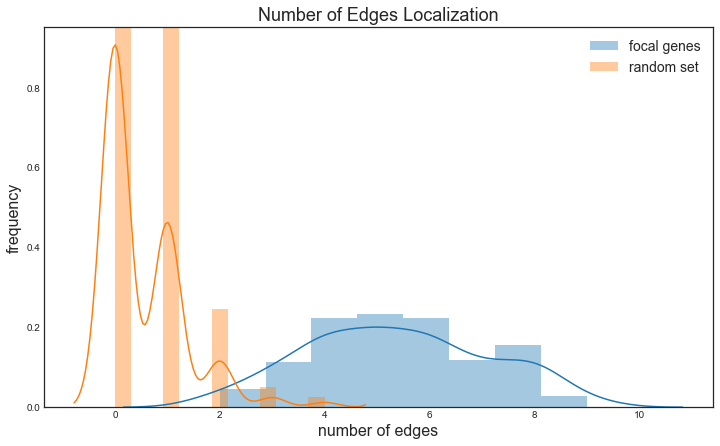

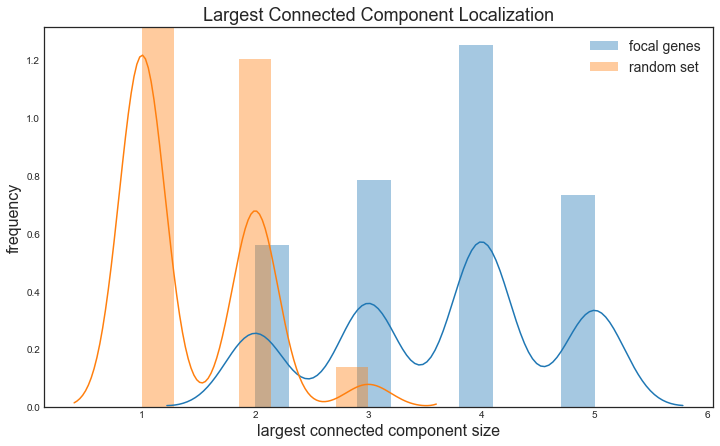

In [182]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 250, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = True)

2.6192605750985365e-08


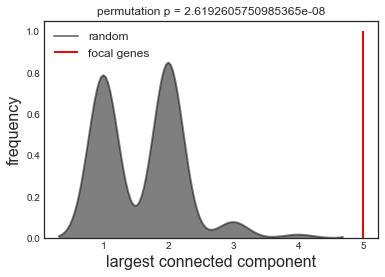

In [184]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 200, 
                                                                          method = 'LCC', 
                                                                          label = 'focal genes',
                                                                          line_height = 1,
                                                                          legend_loc = 'upper left')

## Run Heat Propagation
<a id='heat'></a>

In [16]:
heat.normalized_adj_matrix()

In [17]:
saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

In [18]:
heat.draw_heat_prop(num_nodes = 200,
                  random_walk = True,
                  edge_width = 2,
                  edge_smooth_enabled = True,
                  edge_smooth_type = 'bezier',
                  node_size_multiplier = 5,
                  hover = False,
                  hover_connected_edges = False,
                  largest_connected_component = True,
                  physics_enabled = True,
                  node_font_size = 40,
                  graph_id = 1,
                  node_shadow_x = 6)

## Clustering 
<a id='cluster'></a>

Parameter information:
- **G_DEG**: background network filtered by DEG list, output of load_STRING_to_digraph
- **DG_universe**: full background network, output of create_graph.load_STRING_to_digraph 
- **seed_nodes**: list of DEG's, output of create_graph.create_DEG_list
- **Wprime**: will calculate automatically of not specified, output of visualizations.normalized_adj_matrix
- **num_top_genes**: number of genes to display in the output graph
- **cluster_size_cut_off**: color clusters below this threshhold grey
- **remove_stray_nodes**: remove custers below the cluster size cut off
- **r**: increases spacing between clusters. recommended number between 0.5 and 4.0
- **x_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **y_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **node_spacing**: recommended number between 500 and 2000
- **node_size_multiplier**: as you scale node_spacing, scale this number. Recommended number between 5 and 25
- **physics_enabled**: Nodes will bounce aroound when you click and drag them. Only set to True when number of nodes is 200 or less
- **node_font_size**: as you scale node_spacing, scale this number. Recommended number between 20 and 50
- **graph_id**: Allows rendering of multiple graphs in one notebook. Just make sure each graph has a unique id. 

In [19]:
heat.draw_clustering(rad_positions = False,
                k = None,
                largest_connected_component = True,
                num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 700,
                node_size_multiplier = 10,
                physics_enabled = True,
                node_font_size = 40,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

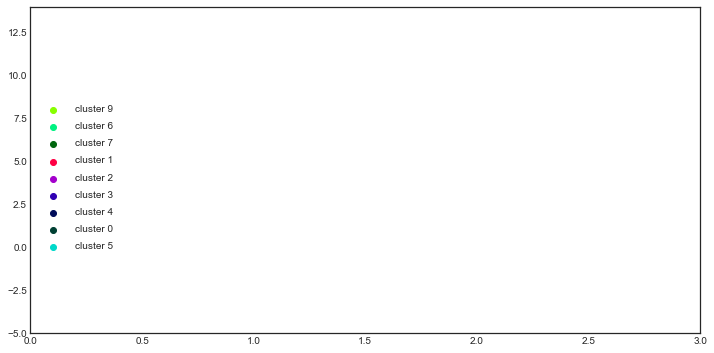

In [20]:
heat.cluster_legend(cluster_size_cut_off = 5)

In [21]:
heat.draw_clustering(num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                r = 0.4,
                node_spacing = 600,
                node_size_multiplier = 4,
                physics_enabled = False,
                node_font_size = 15,
                graph_id = 3,
                node_shadow_x = 6,
                color_lfc = True,
                largest_connected_component = True,
                vmin = -1,
                vmax = 1
               )

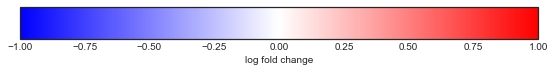

In [22]:
heat.draw_legend(vmin = -1, vmax = 1, label = 'log fold change')

In [23]:
#heat.write_cluster_table('cluster_table_2.csv')